<a href="https://colab.research.google.com/github/Luke-Chesley/API-Sports-Ridge_regression/blob/main/MLB_ridge_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Get data from API in JSON format

In [ ]:
import pandas as pd
import requests
import numpy as np
from operator import delitem
import csv
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
!pip install matplotlib-label-lines
from labellines import labelLine, labelLines


url = "https://v1.baseball.api-sports.io/games?league=1&season=2022"

payload={}
headers = {
  'x-rapidapi-key': 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx',
  'x-rapidapi-host': 'v1.baseball.api-sports.io'
}

response = requests.request("GET", url, headers=headers, data=payload)

data = response.json()

y = data.get('response')



# len(y) = 1170 6/12/22

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
len(y)

2923

Function to parse JSON

In [ ]:
def game_results(num):
  
  y = data.get('response')
  x = (y[num]).get('teams')

  a = x.get('away')
  b = x.get('home')

  away_team = a.get('name')
  home_team = b.get('name')


  z = (y[num]).get('scores')

  c = z.get("home")
  d = z.get('away')

  home_score = c.get('total')
  away_score = d.get('total')

  date = (y[num]).get('date')



  return(date, home_team,home_score, away_team, away_score)



Create blank CSV then write function data to CSV


In [ ]:
blank = pd.DataFrame(list())
blank.to_csv('data.csv')

csv_file = open("data.csv", 'w')

csv_writer = csv.writer(csv_file, delimiter=",")

for i in range(len(y)):
  csv_writer.writerow(game_results(i))

csv_file.close()

Getting CSV data into Data Frame (last 2 lines needed in some years)

In [ ]:
df = pd.read_csv('data.csv')

df.columns = ['date', 'home', 'home_runs', 'away','away_runs']

df['date'] = pd.to_datetime(df['date'])


df['run_difference'] = df['home_runs'] - df['away_runs']

df['home_win'] = np.where(df['run_difference'] < 0,1,0)
df['home_loss'] = np.where(df['run_difference'] > 0,1,0)

df = df[380:] #drop spring training games


df_visitor = pd.get_dummies(df['away'], dtype=np.int64)
df_home = pd.get_dummies(df['home'], dtype=np.int64)


df_model = df_home.sub(df_visitor)
df_model['run_difference'] = df['run_difference']




df_model = df_model.drop('American League', axis=1)
df_model = df_model.drop('National League', axis=1)

Function to clean data (drops null values)

In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame) #df needs to be a pd.DataFrame
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)


df_model = clean_dataset(df_model)


In [ ]:
df_model

,Arizona Diamondbacks,Atlanta Braves,Baltimore Orioles,Boston Red Sox,Chicago Cubs,Chicago White Sox,Cincinnati Reds,Cleveland Guardians,Colorado Rockies,Detroit Tigers,...,Pittsburgh Pirates,San Diego Padres,San Francisco Giants,Seattle Mariners,St.Louis Cardinals,Tampa Bay Rays,Texas Rangers,Toronto Blue Jays,Washington Nationals,run_difference
380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
381,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
383,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-6.0
384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-6.0
2459,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,3.0
2460,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2461,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0


Training ridge regression

In [ ]:
df_train = df_model

lr = Ridge(alpha=.001) 
X = df_train.drop(['run_difference'], axis=1)

y = df_train['run_difference']


lr.fit(X,y)


Ridge(alpha=0.0001)

In [ ]:
df_train

Show sorted coefficents

In [ ]:
df_ratings = pd.DataFrame(data={'team': X.columns, 'rating': lr.coef_})
df_ratings.sort_values(by=['rating'], ascending=False)

,team,rating
13,Los Angeles Dodgers,1.785436
18,New York Yankees,1.449326
10,Houston Astros,1.156253
17,New York Mets,0.937778
25,St.Louis Cardinals,0.931242
1,Atlanta Braves,0.846332
20,Philadelphia Phillies,0.581874
28,Toronto Blue Jays,0.557156
24,Seattle Mariners,0.473581
26,Tampa Bay Rays,0.428509


Function that predicts winner

In [ ]:
def predicted_winner(team_1, team_2):
  
  valid_teams = {'New York Yankees', 'Toronto Blue Jays', 'New York Mets', 'Los Angeles Dodgers',
                   'St.Louis Cardinals',
                   'Boston Red Sox', 'Houston Astros', 'Texas Rangers', 'Los Angeles Angels', 'San Francisco Giants',
                   'Philadelphia Phillies', 'Miami Marlins', 'Atlanta Braves', 'San Diego Padres', 'Minnesota Twins',
                   'Tampa Bay Rays', 'Cleveland Guardians', 'Seattle Mariners', 'Milwaukee Brewers',
                   'Arizona Diamondbacks',
                   'Cincinnati Reds', 'Baltimore Orioles', 'Chicago White Sox', 'Chicago Cubs', 'Colorado Rockies',
                   'Detroit Tigers', 'Oakland Athletics', 'Kansas City Royals', 'Washington Nationals',
                   'Pittsburgh Pirates'

                   }
  if team_1 and team_2 not in valid_teams:
        raise ValueError("results: status must be one of %r." % valid_teams)
  
  
  team_1_rating = df_ratings.iloc[df_ratings[df_ratings['team']== team_1].index.values.astype(int)[0]]['rating']
  team_2_rating = df_ratings.iloc[df_ratings[df_ratings['team']== team_2].index.values.astype(int)[0]]['rating']

  if team_1_rating > team_2_rating:
    print('The', team_1, 'rating is', round(team_1_rating, 3),'.','The', team_1, "are rated", round((team_1_rating- team_2_rating),3), 'points higher than the', team_2,'.' )
  else:
    print('The', team_2, 'rating is', round(team_2_rating, 3),'.','The', team_2, "are rated", round((team_2_rating- team_1_rating),3), 'points higher than the', team_1,  )





In [ ]:
predicted_winner('Boston Red Sox', 'Chicago Cubs')

The Boston Red Sox rating is -0.138 . The Boston Red Sox are rated 0.541 points higher than the Chicago Cubs .


# Win rate over time

In [ ]:
df = pd.read_csv('data.csv')

df.columns = ['date', 'home', 'home_runs', 'away','away_runs']

df['date'] = pd.to_datetime(df['date'])


df['run_difference'] = df['home_runs'] - df['away_runs']

df['home_win'] = np.where(df['run_difference'] < 0,1,0)
df['home_loss'] = np.where(df['run_difference'] > 0,1,0)
df = df.drop(axis=0, index=1875)

df = df[380:] #drop spring training games

df_rating_list = pd.DataFrame()

In [ ]:
for i in range(50, len(df), 10):
  df_visitor = pd.get_dummies(df['away'][0:i], dtype=np.int64)
  df_home = pd.get_dummies(df['home'][0:i], dtype=np.int64)


  df_model = df_home.sub(df_visitor)
  df_model['run_difference'] = df['run_difference'][0:i]


  df_train = clean_dataset(df_model)

  lr = Ridge(alpha=0.001) 
  X = df_train.drop(['run_difference'], axis=1)

  y = df_train['run_difference']


  lr.fit(X,y)


  df_ratings = pd.DataFrame(data={'team': X.columns, 'rating': lr.coef_})

  df_ratings = df_ratings.transpose()

  df_ratings = df_ratings.rename(columns=df_ratings.iloc[0]).drop(df_ratings.index[0])

  df_rating_list = df_rating_list.append(df_ratings)


  df_visitor = pd.DataFrame()
  df_home = pd.DataFrame()
  df_model = pd.DataFrame()
  df_train = pd.DataFrame()
  X = pd.DataFrame()
  y = pd.DataFrame()


df_rating_list.reset_index()
df_rating_list['game'] = np.arange(0, len(df_rating_list))
df_rating_list['game'] = (df_rating_list['game'] - df_rating_list['game'].min()) / (df_rating_list['game'].max() - df_rating_list['game'].min())
df_rating_list.set_index(df_rating_list['game'], inplace=True)
df_rating_list.rename(columns={'game': 'date'}, inplace=True)
df_rating_list.drop(columns='date', inplace=True)



In [ ]:
df_rating_list.plot.line(figsize=(24,14), sort_columns=True)
plt.xlim([0.2,0.8])
plt.ylim([-3,3])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize='xx-large')


labelLines(align=False, fontsize=12)

# Accuracy of model

In [ ]:
df_rating_list['Boston Red Sox'][0]

0.5203490795692313

In [ ]:
df = pd.read_csv('data.csv')
df.columns = ['date', 'home', 'home_runs', 'away','away_runs']
df = df.drop(axis=0, index=1875)
df['date'] = pd.to_datetime(df['date'])

df = df[380:]


In [ ]:
df

,date,home,home_runs,away,away_runs
380,2022-03-29 20:05:00+00:00,Cleveland Guardians,10.0,Milwaukee Brewers,3.0
381,2022-03-29 20:05:00+00:00,Chicago Cubs,3.0,Arizona Diamondbacks,2.0
382,2022-03-29 20:05:00+00:00,San Francisco Giants,11.0,San Diego Padres,6.0
383,2022-03-29 20:05:00+00:00,Texas Rangers,1.0,Cincinnati Reds,7.0
384,2022-03-29 20:10:00+00:00,Seattle Mariners,4.0,Kansas City Royals,11.0
...,...,...,...,...,...
2917,2022-10-05 20:00:00+00:00,Houston Astros,NaN,Philadelphia Phillies,NaN
2918,2022-10-05 20:00:00+00:00,Cleveland Guardians,NaN,Kansas City Royals,NaN
2919,2022-10-05 20:00:00+00:00,Chicago White Sox,NaN,Minnesota Twins,NaN
2920,2022-10-05 20:00:00+00:00,Boston Red Sox,NaN,Tampa Bay Rays,NaN


In [ ]:
len(df)/3

847.0

In [ ]:
# % through df and compare the 2 teams. Get predicted and true winner. last 2 / 3 of df_rating_list

df = df[800:].reset_index()


In [ ]:
len(df)

1741

In [ ]:
1/1742 + 1/3

0.3339073861461921

In [ ]:
df['away'][10]

'Cleveland Guardians'

In [ ]:
df['home'][10]

'Detroit Tigers'

In [ ]:
df['home_runs'][10]

2.0

In [ ]:
df['away_runs'][10]

1.0

In [ ]:
def closest(lst, K):
      
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [ ]:
df_rating_list

In [ ]:
df_rating_list['Cleveland Guardians'][closest(df_rating_list.index, (1/1742 + 1/3))]

-0.07794215824395329

In [ ]:
df_rating_list[df['home'][10]][closest(df_rating_list.index, (1/1742 + 1/3))]

-0.9472259043142942

In [ ]:
def model_eval(index):
  home_runs = df['home_runs'][index]
  away_runs = df['away_runs'][index]
  if home_runs > away_runs:
    true_winner = df['home'][index]
  else:
    true_winner = df['away'][index]

  home_pred = df_rating_list[df['home'][index]][closest(df_rating_list.index, (index/len(df) + 1/3))]

  away_pred = df_rating_list[df['away'][index]][closest(df_rating_list.index, (index/len(df) + 1/3))]

  if home_pred > away_pred:
    pred_winner = df['home'][index]
  else:
    pred_winner = df['away'][index]
  
  if true_winner == pred_winner:
    return 1
  else:
    return 0


In [ ]:
test = []

In [ ]:
len(df)

1741

In [ ]:
for i in range(len(df)):
  test.append(model_eval(i))

In [ ]:
win_rate = sum(test) / len(test)

In [ ]:
win_rate

0.5761056863871339

# Moving Average 

In [ ]:
df_tester = df_rating_list

In [ ]:
df_tester

,Arizona Diamondbacks,Atlanta Braves,Baltimore Orioles,Boston Red Sox,Chicago Cubs,Chicago White Sox,Cincinnati Reds,Cleveland Guardians,Colorado Rockies,Detroit Tigers,...,Philadelphia Phillies,Pittsburgh Pirates,San Diego Padres,San Francisco Giants,Seattle Mariners,St.Louis Cardinals,Tampa Bay Rays,Texas Rangers,Toronto Blue Jays,Washington Nationals
game,,,,,,,,,,,,,,,,,,,,,
0.000000,-1.25464,-1.027745,0.748167,0.520349,-4.143165,5.154796,2.907741,-2.00136,-5.97313,-1.144277,...,-2.646801,-0.251832,-3.916671,3.809629,-4.855569,5.4378,3.04692,2.247679,1.953691,-5.878141
0.004016,0.860049,-5.090647,1.343009,-2.543357,-1.643878,2.978551,0.790005,-1.405478,-3.598057,0.930087,...,0.330207,0.718294,-0.941587,5.418029,-3.949997,5.332393,-0.605209,0.902279,3.204689,-5.930818
0.008032,1.902953,-4.128786,0.128977,-1.783343,-1.130105,1.408032,0.773717,-1.307362,-3.386386,-0.10239,...,-0.187495,-0.480356,-1.034454,5.295642,-3.512356,6.091186,1.191759,0.521515,2.432675,-3.158817
0.012048,0.323418,-4.182757,0.078418,-1.720072,-0.936964,-0.55707,2.357755,-2.01878,-1.217962,-0.171119,...,-0.166282,-0.393589,-1.942697,5.425217,-2.668332,5.914972,1.150668,1.19132,2.516293,-2.915931
0.016064,0.639866,-2.569759,-1.020558,-1.078519,0.079765,-1.651031,2.528388,-1.958358,-1.330709,0.23782,...,-0.644297,0.01173,-0.897115,5.013895,-2.532827,4.654168,-0.138297,-0.066508,1.931376,-1.655128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.983936,-0.165484,0.837662,0.153707,-0.197128,-0.64291,-0.42635,-0.688864,-0.025681,-0.935447,-1.004462,...,0.5838,-1.544699,0.088503,0.088357,0.43293,0.93096,0.410802,0.074191,0.539459,-1.456752
0.987952,-0.165484,0.837662,0.153707,-0.197128,-0.64291,-0.42635,-0.688864,-0.025681,-0.935447,-1.004462,...,0.5838,-1.544699,0.088503,0.088357,0.43293,0.93096,0.410802,0.074191,0.539459,-1.456752
0.991968,-0.165484,0.837662,0.153707,-0.197128,-0.64291,-0.42635,-0.688864,-0.025681,-0.935447,-1.004462,...,0.5838,-1.544699,0.088503,0.088357,0.43293,0.93096,0.410802,0.074191,0.539459,-1.456752


In [ ]:
df_tester = df_tester.rolling(5).mean()

[Text(0.2474193548387097, -0.008877864055219455, 'Arizona Diamondbacks'),
 Text(0.26483870967741935, -0.5362871381958747, 'Atlanta Braves'),
 Text(0.28225806451612906, -0.6804847206927314, 'Baltimore Orioles'),
 Text(0.2996774193548387, 0.292727720961555, 'Boston Red Sox'),
 Text(0.3170967741935484, -0.5332335737290331, 'Chicago Cubs'),
 Text(0.3345161290322581, -1.204919841855326, 'Chicago White Sox'),
 Text(0.35193548387096774, -0.69633129315513, 'Cincinnati Reds'),
 Text(0.36935483870967745, -0.004294207190465152, 'Cleveland Guardians'),
 Text(0.38677419354838716, -1.1719385793118107, 'Colorado Rockies'),
 Text(0.4041935483870968, -1.0862492518775329, 'Detroit Tigers'),
 Text(0.42161290322580647, 0.7080073002296202, 'Houston Astros'),
 Text(0.4390322580645162, -1.2441883192483938, 'Kansas City Royals'),
 Text(0.45645161290322583, 0.4588209388432709, 'Los Angeles Angels'),
 Text(0.4738709677419355, 1.3199042295638737, 'Los Angeles Dodgers'),
 Text(0.4912903225806452, -0.0291662387618

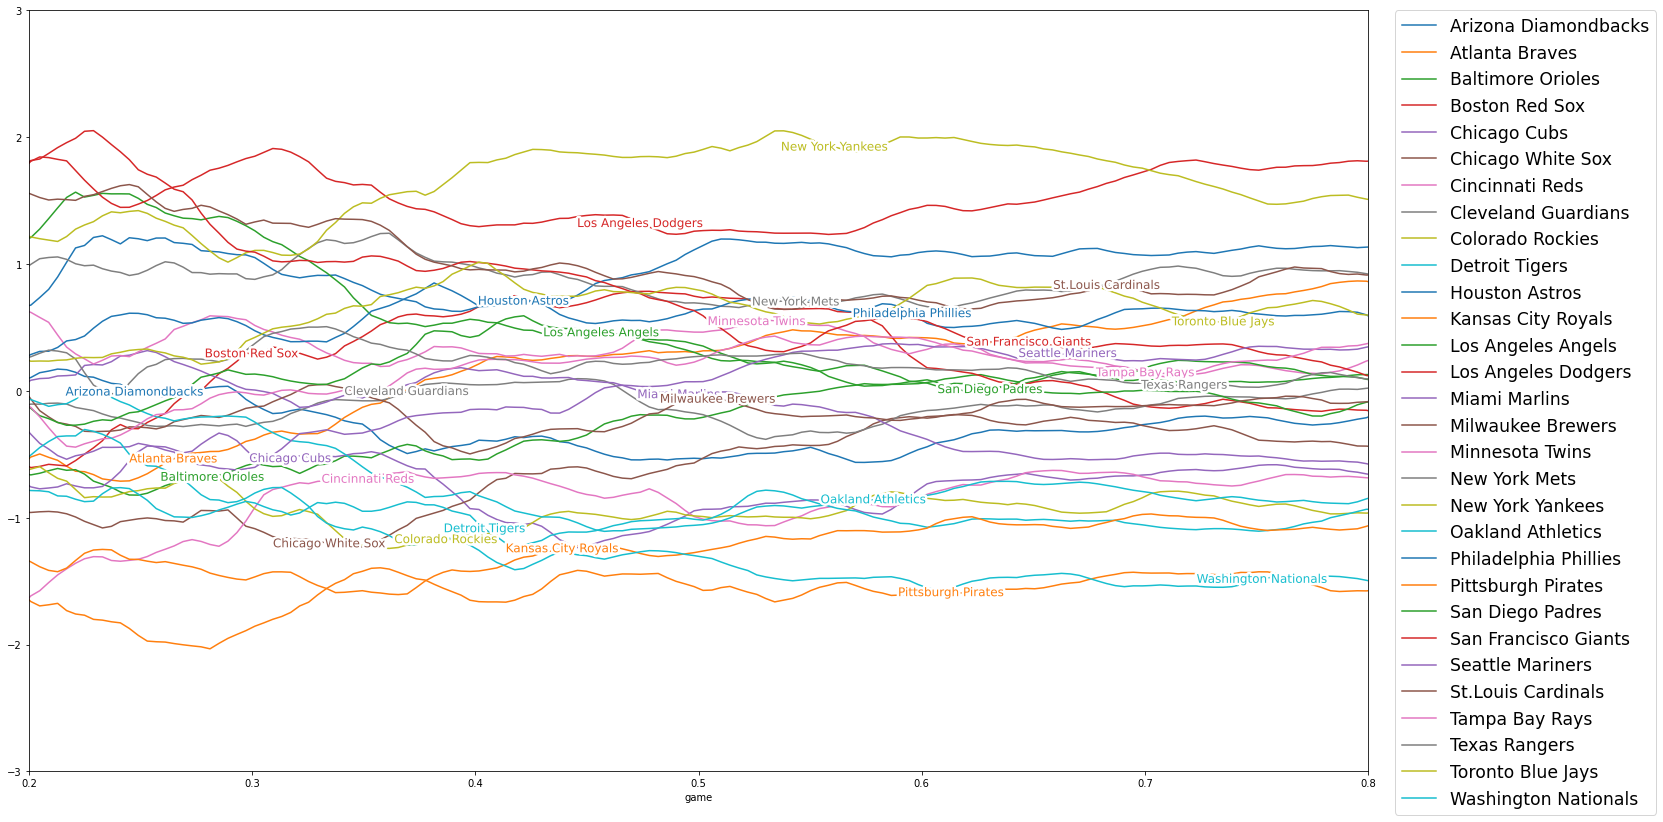

In [ ]:
df_tester.plot.line(figsize=(24,14), sort_columns=True)
plt.xlim([0.2,0.8])
plt.ylim([-3,3])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize='xx-large')


labelLines(align=False, fontsize=12)